In [1]:
# Utility
from tqdm.notebook import tqdm
from typing import Union
import os

# Math and data manipulation
import numpy as np
import pandas as pd 
import random

# Datetime object manipulation
from datetime import datetime as dt

# Data Visualization
import matplotlib.pyplot as plt

# Data preprocessing

# Machine learning model
import tensorflow as tf

# Model Evaluation
from sklearn.metrics import mean_squared_error as MSE

# Parameter
SEED = 896
N_EPOCH = 100
TRAIN_SIZE = 0.7
DARK_THEME = 1
PLOT_SIZE = (17,7)

#Set Seed
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Set Plot Configuration
if DARK_THEME:
    import mplcyberpunk
    plt.style.use('cyberpunk')
else:
    plt.style.use('seaborn-v0_8')

plt.rcParams['figure.figsize'] = PLOT_SIZE 
# plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['axes.facecolor'] = 'white'

In [2]:
data = pd.read_csv('Data/Data Inflasi.csv', dayfirst=True, parse_dates=[0])[::-1]
data = data.set_index('Periode')

In [3]:
data.describe()

,Data Inflasi
count,240.000000
mean,5.705417
std,3.347665
min,1.320000
25%,3.345000
50%,5.080000
75%,6.990000
max,18.380000


In [5]:
train = data[:int(len(data)*TRAIN_SIZE)]
test = data[int(len(data)*TRAIN_SIZE):]

In [6]:
train.describe()

,Data Inflasi
count,168.000000
mean,6.876488
std,3.301116
min,2.410000
25%,4.577500
50%,6.330000
75%,7.465000
max,18.380000


In [7]:
test.describe()

,Data Inflasi
count,72.000000
mean,2.972917
std,1.129572
min,1.320000
25%,1.937500
50%,3.130000
75%,3.505000
max,5.950000


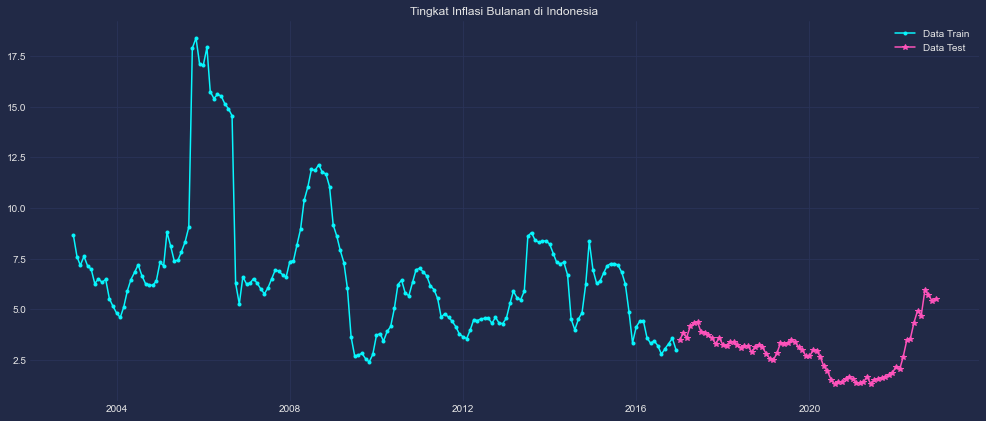

In [4]:
plt.title('Tingkat Inflasi Bulanan di Indonesia')
plt.plot(train, label='Data Train',marker='.')
plt.plot(test, label='Data Test', marker='*')
plt.legend()
plt.show()

In [5]:
def partition(sequence_length, data):
    """Function to

    Args:
        sequence_length (_type_): _description_
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    x, y = [], []
    data = np.array(data)
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i])
        y.append(data[i:i+1])
    
    x = np.array(x)
    y = np.array(y)
    return x, y

In [6]:
architectures = []
base = (5,5,5)
for i in range(-1,2):
    for j in range(-1,2):
        architectures.append([base[0]+i]*(len(base)+j))

In [7]:
def create_model(architecture: Union[tuple,list], seed=42):
    """Creating tensorflow model easier

    Args:
        architecture (tuple | list): Architecture of ANN model
        seed (int, optional): Random number seed. Defaults to 42.

    Returns:
        model: Tensorflow model
    """
    
    model = tf.keras.models.Sequential(
        tf.keras.layers.Flatten()
    )

    initializer = tf.keras.initializers.he_uniform(seed)

    for neuron in architecture[1:]:
        model.add(
            tf.keras.layers.Dense(
                units = neuron, 
                activation = 'relu', 
                kernel_initializer = initializer, 
                bias_initializer = initializer
                )
            )

    model.add(tf.keras.layers.Dense(1))
    # model.add(tf.keras.layers.Reshape([1, -1]),)

    optimizer = tf.keras.optimizers.Adam()

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=optimizer,
        )
    
    return model

In [8]:
def forecast(model, last_data, n):
    y = np.array([])
    len_input = len(last_data[0])

    for i in range(n):
        pred = model.predict(last_data, verbose=0)
        last_data = np.append(last_data[:,1:], pred).reshape(-1, len_input)
        y = np.append(y, pred)
        
    return y

In [9]:
histories = []
models = []
names = []
preds = []
mse = []
for architecture in architectures:
    x_train, y_train = partition(architecture[0], train)

    model = create_model(architecture, seed=SEED)

    history = model.fit(
                x=x_train,
                y=y_train,
                epochs=N_EPOCH,
                verbose=0, 
            )
    
    name = "-".join(map(str, architecture))
    model.save(f'Model/{name}.h5')

    y_pred = forecast(model, train[-architecture[0]:].values.T, len(test)+12)
    error = MSE(test, y_pred[:-12])
    
    histories.append(history)
    models.append(model)
    names.append(name)
    preds.append(y_pred)
    mse.append(error)


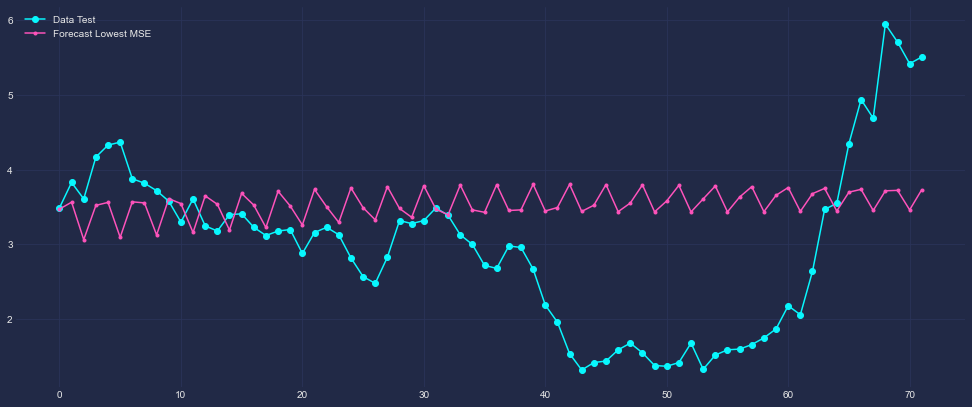

In [10]:
plt.plot(test.values, marker='o', label='Data Test')
plt.plot(preds[mse.index(min(mse))][:-12], marker='.', label='Forecast Lowest MSE')
plt.legend()
plt.show()

In [11]:
mse

[10.14589375712489,
 7.834037963388194,
 2.3363499563812544,
 5.184716607659212,
 1.7490453860116792,
 1.6627072212706975,
 2.438138467669357,
 3.828996445314307,
 2.5181474857337105]

In [12]:
output = pd.DataFrame(dict(zip(names, preds)))

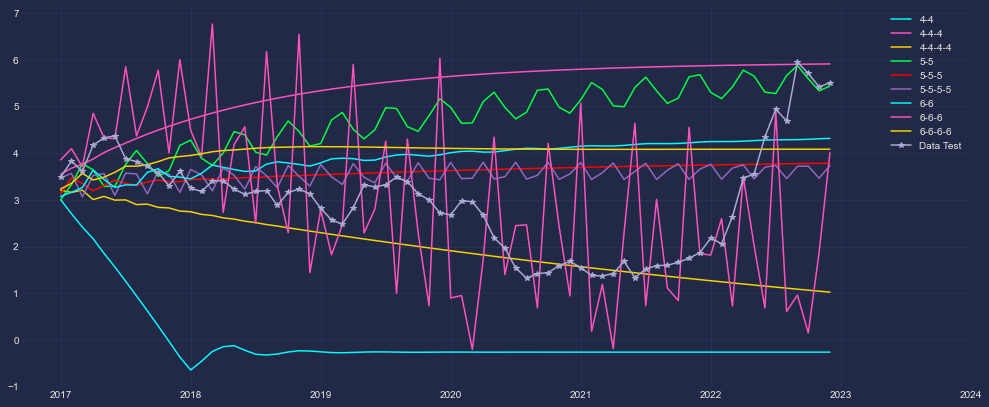

In [13]:
ax = output[:-12].plot()
plt.plot(test.values, label='Data Test', marker='*', color='#aaaad3')
ax.set_xticks(list(range(0, len(output)+1,12)), list(range(2017,2025)))
plt.legend()
plt.show()

In [14]:
idx = pd.date_range(test.index[0],freq='MS', periods=len(test)+12)

In [15]:
predict = output.set_index(idx)
predict.index = predict.index.rename('Periode')

In [16]:
# predict.to_csv('Output/Predict.csv', float_format='%.2f')

In [17]:
histories = []
models = []
future = []
for architecture in architectures:
    x_train, y_train = partition(architecture[0], data)

    model = create_model(architecture, seed=SEED)

    history = model.fit(
                x=x_train,
                y=y_train,
                epochs=N_EPOCH,
                verbose=0, 
            )
    
    # model.save(f'Model/{name}.h5')

    y_pred = forecast(model, data[-architecture[0]:].values.T,12)
    
    histories.append(history)
    models.append(model)
    names.append(name)
    future.append(y_pred)


In [18]:
futures = pd.DataFrame(dict(zip(names, future)))

In [19]:
futures = futures.set_index(pd.date_range('1/1/2023',freq='MS',periods=12))
futures.index = futures.index.rename('Periode')

<AxesSubplot: xlabel='Periode'>

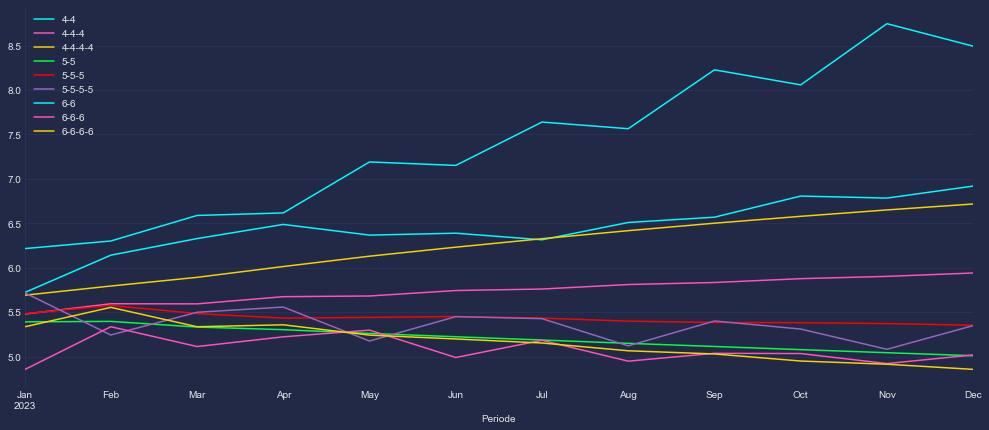

In [20]:
futures.plot()

In [21]:
# futures.to_csv('Output/Forecast.csv', float_format='%.2f')